In [24]:
import os
import sys
import pickle as pkl
import warnings 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from sklearn.cluster import AgglomerativeClustering

import massPy as mp

from utils import get_frame_number, get_defect_list, get_clustering, \
    gen_clustering_metadata, get_defect_arr_from_frame, estimate_size_reduction
from plot_utils import *

plt.style.use('sg_article')

In [2]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

In [16]:
## Choose which dataset to visualize
act = 0.022
act_idx = act_vl.index(act)
num_exp = 0
rmax = 33
folder_path = os.path.join(act_dir_vl[act_idx], f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')
labels_path = os.path.join(folder_path, 'labels_rm33.pkl')

with open(defect_path, 'rb') as f:
    defect_list = pkl.load(f)
with open(labels_path, 'rb') as f:
    labels = pkl.load(f)

In [78]:
f_idx = 4
defect_arr = get_defect_arr_from_frame(defect_list[f_idx])

defect_positions = np.empty([len(defect_list[0]), 3], dtype='float')
for i, defs in enumerate(defect_list[0]):    
    defect_positions[i] = *defs['pos'], defs['charge']



In [ ]:
# Parameters for clustering
method_kwargs = dict(n_clusters=None, linkage='single', distance_threshold=rmax)
cst = AgglomerativeClustering(**method_kwargs)
single_cluster = cst.fit_predict(defect_arr)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9,8))

# Get unique cluster labels
vals = np.unique(single_cluster)

# Calculate the number of members in each cluster
cluster_sizes = [np.sum(single_cluster == val) for val in vals]

# Normalize cluster sizes for the colormap
norm = Normalize(vmin=min(cluster_sizes), vmax=max(cluster_sizes))
cmap = cm.viridis
marker_list = ['+', 's', 'd', 'v', '^', '<', '>', '1', '2', '*', 'H', '+', 'D', 'p', '.', 'o',]

# Scatter plot with colors based on cluster size
for j, val in enumerate(vals):
    idx = np.where(single_cluster == val)
    Nmembers = len(idx[0])
    color = cmap(norm(Nmembers))  # Get color from colormap

    ax.scatter(defect_arr[idx, 0], defect_arr[idx, 1], color=color, marker=marker_list[Nmembers - 1], s=35, label=f'Cluster {val}')

# Add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Points in Cluster')

# Set plot title and labels
ax.set_title(f'Rmax = {rmax}')
ax.axis('equal');
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')



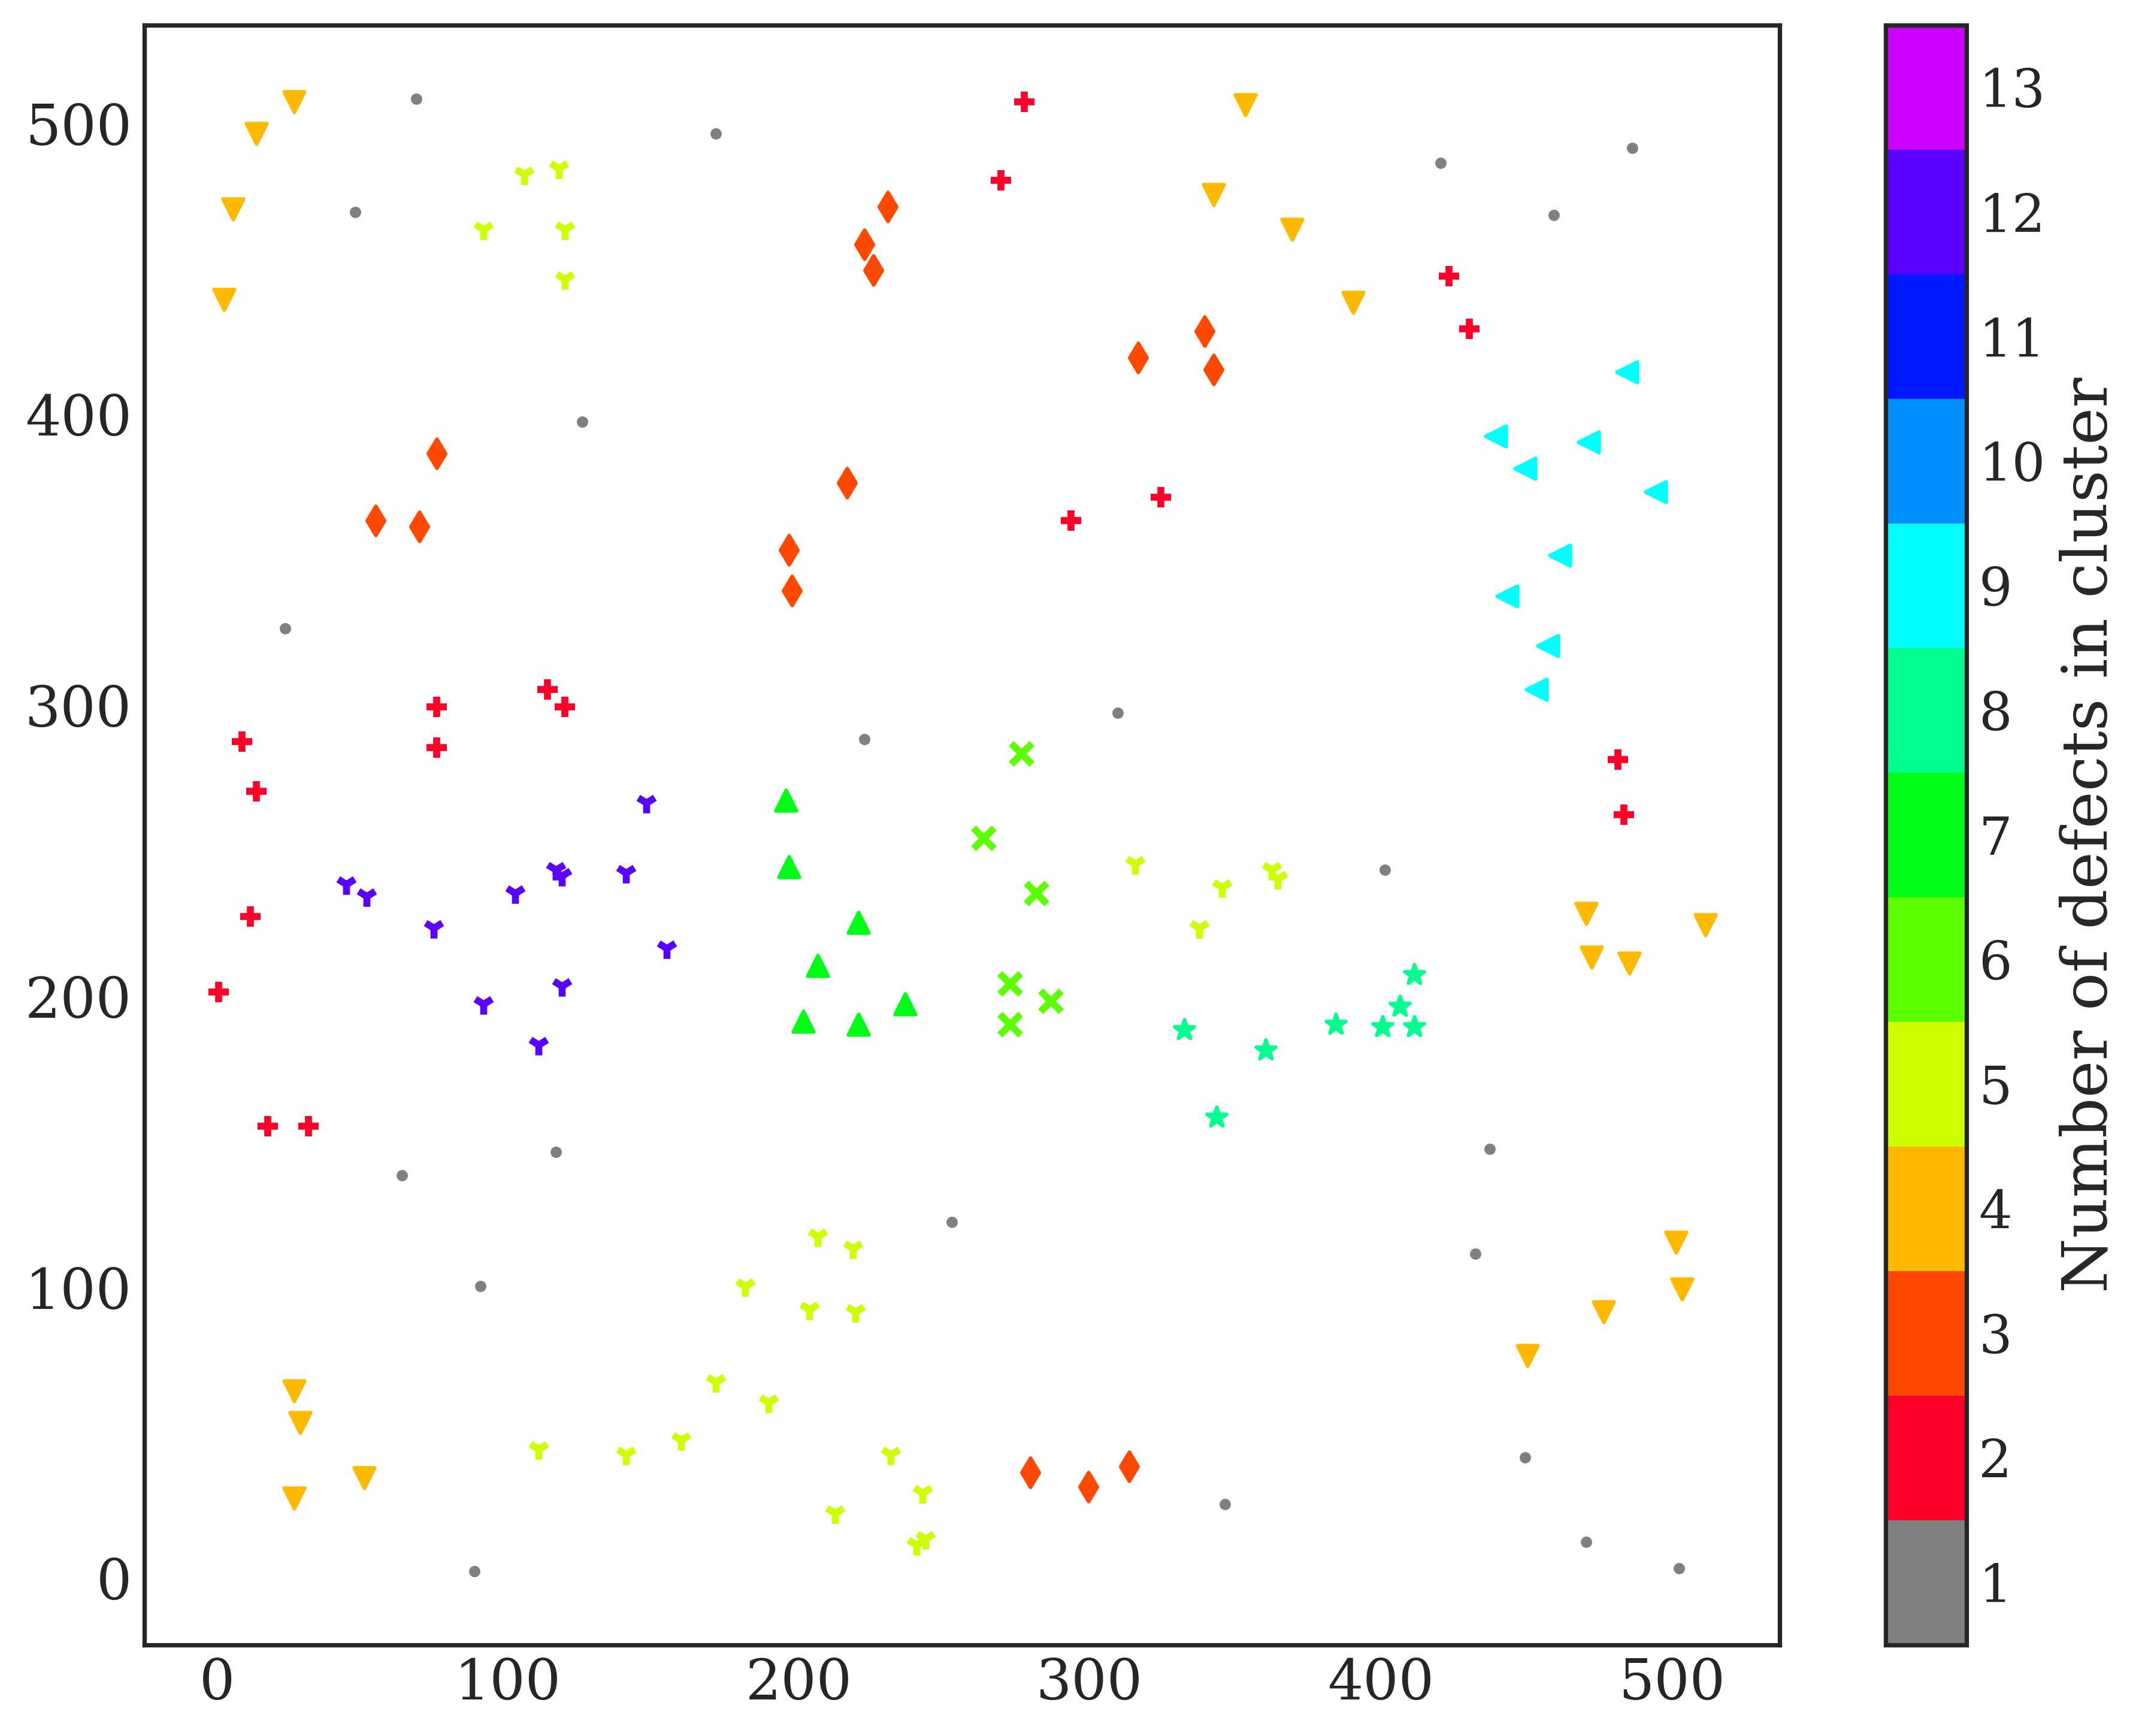

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap, BoundaryNorm

# Parameters for clustering
dist = 33 # Replace with your distance threshold
extra_colors = 1
frame = 65

defect_arr = get_defect_arr_from_frame(defect_list[frame])
single_cluster = labels[frame]
#method_kwargs = dict(n_clusters=None, linkage='single', distance_threshold=dist)
#cst = AgglomerativeClustering(**method_kwargs)
#single_cluster = cst.fit_predict(defect_arr)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9,7))

# Get unique cluster labels
vals = np.unique(single_cluster)

# Calculate the number of members in each cluster
cluster_sizes = [np.sum(single_cluster == val) for val in vals]

# Define the discrete rainbow colormap
num_colors = max(cluster_sizes) + extra_colors
colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_colors))
colors = np.r_['0,2', np.array([.5, .5, .5, 1.0]), colors]
cmap = ListedColormap(colors )

# Normalize cluster sizes to fit the colormap
norm = BoundaryNorm(np.arange(1, num_colors + 2) - 0.5, num_colors)
marker_list = ['.', '+', 'd', 'v', '1', 'x', '^', '*', '<', '>', 's', '1', '2', '*', 'H', '+', 'D', 'p', 'o',]
marker_counter = []

# Scatter plot with colors based on cluster size
for val in vals:
    idx = np.where(single_cluster == val)
    Nmembers = len(idx[0])
    
    if Nmembers not in marker_counter:
        marker_counter.append(Nmembers)
    marker_idx = marker_counter.index(Nmembers)
    marker_idx = Nmembers -1
    marker_size = 20 if Nmembers == 1 else 35
    color = cmap(Nmembers-1)  # Get color from colormap, -1 to align with 0-based index
   # color = 'grey' if Nmembers == 1 else cmap(Nmembers - 1)
    ax.scatter(defect_arr[idx, 0], defect_arr[idx, 1], marker = marker_list[marker_idx],\
                color=color, s=marker_size, label=f'Cluster {val}')

# Add a colorbar with discrete colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of defects in cluster')
cbar.set_ticks(np.arange(1, num_colors + 1))
cbar.set_ticklabels(np.arange(1, num_colors + 1), fontsize=15)


# Set plot title and labels
#ax.set_title(f'Rmax = {rmax}')
ax.set_aspect('equal')
plt.tick_params(labelsize = 16)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
#ax.set_xticklabels(labels=range(0,600,100), fontsize=18)

In [146]:
for i in range(0,600,100):
    print(i)

0
100
200
300
400
500


In [128]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize=(14,7*nrows))
ax = ax.flatten()

frame_list = [0,1,2,3, 4, 5]
for i, frame in enumerate(frame_list):
    frame += 60
    defect_arr = get_defect_arr_from_frame(defect_list[frame])

  #  method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=dist)
   # cst = AgglomerativeClustering(**method_kwargs)
    #single_cluster = cst.fit_predict(defect_arr)
    single_cluster = labels[frame]

    vals = np.unique(single_cluster)
    ax[i].set_title(f'Rmax = {dist}')

    color_list = ['blue', 'orange', 'purple', 'pink', 'yellow', 'brown', 'grey', 'cyan', 'magenta']
    marker_list = ['+', 's', 'd', 'v', '^', '<', '>', 'p',]
    for val in vals:
        idx = np.where(single_cluster == val)
      #  print(len(idx[0]))
        Nmembers = len(idx[0])
        if Nmembers == 1:
            color = 'black'
            marker = '.'
        elif Nmembers == 2:
            color = 'red'
            marker = 'o'
        elif Nmembers > 10:
            color = 'green'
            marker = 'x'
        else:
            color = color_list[Nmembers - 3]
            marker = marker_list[Nmembers - 3]

        ax[i].scatter(defect_arr[idx,0], defect_arr[idx,1], c = color, marker = marker, s=35)
fig.text(0.05, .975, f'n=1 ', fontsize=14, verticalalignment='bottom', color='black', fontweight='bold')
fig.text(0.1, .975, f'n=2 ', fontsize=14, verticalalignment='bottom', color='red', fontweight='bold')
for i in range(3, 10):
    fig.text(i*0.05, .975, f'n={i} ', fontsize=14, verticalalignment='bottom', color=color_list[i-3], fontweight='bold')
#fig.text(0.3, 1.015, f'n=3 ', fontsize=14, verticalalignment='bottom', color=color_list[3-3], fontweight='bold')
fig.text(10*0.05, .975, f'n>10 ', fontsize=14, verticalalignment='bottom', color='green', fontweight='bold')

Text(0.5, 0.975, 'n>10 ')

In [125]:
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize=(14,7*nrows))
ax = ax.flatten()

frame_list = [0,1,2,3, 4, 5]
for i, frame in enumerate(frame_list):
    defect_arr = get_defect_arr_from_frame(defect_list[frame])

    method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=dist)
    cst = AgglomerativeClustering(**method_kwargs)
    single_cluster = cst.fit_predict(defect_arr)
    single_cluster = labels[frame]

    vals = np.unique(single_cluster)
    ax[i].set_title(f'Rmax = {dist}')

    color_list = ['blue', 'orange', 'purple', 'pink', 'yellow', 'brown', 'grey', 'cyan', 'magenta']
    marker_list = ['+', 's', 'd', 'v', '^', '<', '>', 'p',]
    for val in vals:
        idx = np.where(single_cluster == val)
      #  print(len(idx[0]))
        Nmembers = len(idx[0])
        if Nmembers == 1:
            color = 'black'
            marker = '.'
        elif Nmembers == 2:
            color = 'red'
            marker = 'o'
        elif Nmembers > 10:
            color = 'green'
            marker = 'x'
        else:
            color = color_list[Nmembers - 3]
            marker = marker_list[Nmembers - 3]

        ax[i].scatter(defect_arr[idx,0], defect_arr[idx,1], c = color, marker = marker, s=35)
fig.text(0.05, .975, f'n=1 ', fontsize=14, verticalalignment='bottom', color='black', fontweight='bold')
fig.text(0.1, .975, f'n=2 ', fontsize=14, verticalalignment='bottom', color='red', fontweight='bold')
for i in range(3, 10):
    fig.text(i*0.05, .975, f'n={i} ', fontsize=14, verticalalignment='bottom', color=color_list[i-3], fontweight='bold')
#fig.text(0.3, 1.015, f'n=3 ', fontsize=14, verticalalignment='bottom', color=color_list[3-3], fontweight='bold')
fig.text(10*0.05, .975, f'n>10 ', fontsize=14, verticalalignment='bottom', color='green', fontweight='bold')

Text(0.5, 0.975, 'n>10 ')

In [ ]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize=(14,7*nrows))
ax = ax.flatten()
f = get_frame_number(f_idx, paths[N], ar.ninfo)
frame=ar._read_frame(f)
mp.nematic.plot.director(frame, ax[0]);
mp.nematic.plot.defects(frame, ax[0]);

dist_max = [33]
for i, dist in enumerate(dist_max):
    
    method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=dist)
    cst = AgglomerativeClustering(**method_kwargs)
    single_cluster = cst.fit_predict(defect_positions)
   # single_cluster  = AgglomerativeClustering(metric = lambda arr: calc_distance(arr, ar.LX, periodic = False), n_clusters=None, linkage = 'single', distance_threshold=dist).fit_predict(defect_arr)
  #  ax[i+1].fill(x, y, facecolor='lightsalmon', edgecolor='orangered', linewidth=3)
   # ax[i + 1].scatter(defect_arr[:,0], defect_arr[:,1], c=single_cluster, cmap= 'tab20', s=8, lw=2)
   # ax[i + 1].plot(defect_arr[:,0], defect_arr[:,1], 'o', c=single_cluster, markersize=8, cmap= 'tab20',  alpha=0.5)
    vals = np.unique(single_cluster)
    ax[i+1].set_title(f'Rmax = {dist}')

    color_list = ['blue', 'orange', 'purple', 'pink', 'yellow', 'brown', 'grey', 'cyan', 'magenta']
    marker_list = ['+', 's', 'd', 'v', '^', '<', '>', 'p',]
    for val in vals:
        idx = np.where(single_cluster == val)
      #  print(len(idx[0]))
        Nmembers = len(idx[0])
        if Nmembers == 1:
            color = 'black'
            marker = '.'
        elif Nmembers == 2:
            color = 'red'
            marker = 'o'
        elif Nmembers > 10:
            color = 'green'
            marker = 'x'
        else:
            color = color_list[Nmembers - 3]
            marker = marker_list[Nmembers - 3]

        ax[i+1].scatter(defect_arr[idx,0], defect_arr[idx,1], c = color, marker = marker, s=35)
fig.text(0.05, .975, f'n=1 ', fontsize=14, verticalalignment='bottom', color='black', fontweight='bold')
fig.text(0.1, .975, f'n=2 ', fontsize=14, verticalalignment='bottom', color='red', fontweight='bold')
for i in range(3, 10):
    fig.text(i*0.05, .975, f'n={i} ', fontsize=14, verticalalignment='bottom', color=color_list[i-3], fontweight='bold')
#fig.text(0.3, 1.015, f'n=3 ', fontsize=14, verticalalignment='bottom', color=color_list[3-3], fontweight='bold')
fig.text(10*0.05, .975, f'n>10 ', fontsize=14, verticalalignment='bottom', color='green', fontweight='bold')

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(10,15))
ax = ax.flatten()
frame=ar._read_frame(f)
mp.nematic.plot.director(frame, ax[0]);
mp.nematic.plot.defects(frame, ax[0]);
ax[1].scatter(defect_arr[:,0], defect_arr[:,1], c=ap_clustering, cmap='viridis', s=8)
ax[2].scatter(defect_arr[:,0], defect_arr[:,1], c=ward_cluster, cmap='viridis', s=8)
ax[3].scatter(defect_arr[:,0], defect_arr[:,1], c=av_cluster, cmap='viridis', s=8)
ax[4].scatter(defect_arr[:,0], defect_arr[:,1], c=single_cluster, cmap= 'tab20c_r', s=8)
mp.nematic.plot.director(frame, ax[-1]);
mp.nematic.plot.defects(frame, ax[-1]);